In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                            | 0/50000 [00:00<?, ?it/s]

  9%|██████████▍                                                                                                   | 4748/50000 [00:00<00:00, 47471.90it/s]

 19%|████████████████████▉                                                                                         | 9524/50000 [00:00<00:00, 47635.97it/s]

 29%|███████████████████████████████▏                                                                             | 14318/50000 [00:00<00:00, 47773.92it/s]

 38%|█████████████████████████████████████████▋                                                                   | 19096/50000 [00:00<00:00, 47739.63it/s]

 48%|████████████████████████████████████████████████████                                                         | 23872/50000 [00:00<00:00, 47745.39it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 28653/50000 [00:00<00:00, 47765.62it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 33430/50000 [00:00<00:00, 47735.60it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 38215/50000 [00:00<00:00, 47770.85it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▋               | 42996/50000 [00:00<00:00, 47782.39it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 47775/50000 [00:01<00:00, 47778.35it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 47746.73it/s]

Files already downloaded and verified


  0%|                                                                                                                            | 0/10000 [00:00<?, ?it/s]

 48%|████████████████████████████████████████████████████▍                                                         | 4767/10000 [00:00<00:00, 47658.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9533/10000 [00:00<00:00, 47316.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 47158.80it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 xfy981ny


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-xfy981ny:best, 58.53MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▊                                                                                                                     | 1/157 [00:00<01:48,  1.44it/s]

  2%|██▎                                                                                                                   | 3/157 [00:00<00:35,  4.35it/s]

  3%|███▊                                                                                                                  | 5/157 [00:00<00:22,  6.86it/s]

  4%|█████▎                                                                                                                | 7/157 [00:01<00:16,  8.92it/s]

  6%|██████▊                                                                                                               | 9/157 [00:01<00:14, 10.55it/s]

  7%|████████▏                                                                                                            | 11/157 [00:01<00:12, 11.80it/s]

  8%|█████████▋                                                                                                           | 13/157 [00:01<00:11, 12.74it/s]

 10%|███████████▏                                                                                                         | 15/157 [00:01<00:10, 13.42it/s]

 11%|████████████▋                                                                                                        | 17/157 [00:01<00:10, 13.91it/s]

 12%|██████████████▏                                                                                                      | 19/157 [00:01<00:09, 14.27it/s]

 13%|███████████████▋                                                                                                     | 21/157 [00:02<00:09, 14.52it/s]

 15%|█████████████████▏                                                                                                   | 23/157 [00:02<00:09, 14.70it/s]

 16%|██████████████████▋                                                                                                  | 25/157 [00:02<00:08, 14.83it/s]

 17%|████████████████████                                                                                                 | 27/157 [00:02<00:08, 14.92it/s]

 18%|█████████████████████▌                                                                                               | 29/157 [00:02<00:08, 14.98it/s]

 20%|███████████████████████                                                                                              | 31/157 [00:02<00:08, 15.02it/s]

 21%|████████████████████████▌                                                                                            | 33/157 [00:02<00:08, 15.05it/s]

 22%|██████████████████████████                                                                                           | 35/157 [00:02<00:08, 15.06it/s]

 24%|███████████████████████████▌                                                                                         | 37/157 [00:03<00:07, 15.08it/s]

 25%|█████████████████████████████                                                                                        | 39/157 [00:03<00:07, 15.10it/s]

 26%|██████████████████████████████▌                                                                                      | 41/157 [00:03<00:07, 15.11it/s]

 27%|████████████████████████████████                                                                                     | 43/157 [00:03<00:07, 15.11it/s]

 29%|█████████████████████████████████▌                                                                                   | 45/157 [00:03<00:07, 15.11it/s]

 30%|███████████████████████████████████                                                                                  | 47/157 [00:03<00:07, 15.11it/s]

 31%|████████████████████████████████████▌                                                                                | 49/157 [00:03<00:07, 15.11it/s]

 32%|██████████████████████████████████████                                                                               | 51/157 [00:04<00:07, 15.11it/s]

 34%|███████████████████████████████████████▍                                                                             | 53/157 [00:04<00:06, 15.11it/s]

 35%|████████████████████████████████████████▉                                                                            | 55/157 [00:04<00:06, 15.11it/s]

 36%|██████████████████████████████████████████▍                                                                          | 57/157 [00:04<00:06, 15.11it/s]

 38%|███████████████████████████████████████████▉                                                                         | 59/157 [00:04<00:06, 15.10it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 61/157 [00:04<00:06, 15.10it/s]

 40%|██████████████████████████████████████████████▉                                                                      | 63/157 [00:04<00:06, 15.10it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 65/157 [00:04<00:06, 15.08it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 67/157 [00:05<00:05, 15.08it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 69/157 [00:05<00:05, 15.07it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 71/157 [00:05<00:05, 15.07it/s]

 46%|██████████████████████████████████████████████████████▍                                                              | 73/157 [00:05<00:05, 15.07it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 75/157 [00:05<00:05, 15.07it/s]

 49%|█████████████████████████████████████████████████████████▍                                                           | 77/157 [00:05<00:05, 15.06it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 79/157 [00:05<00:05, 15.06it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 81/157 [00:05<00:05, 15.08it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 83/157 [00:06<00:04, 15.07it/s]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 85/157 [00:06<00:04, 15.07it/s]

 55%|████████████████████████████████████████████████████████████████▊                                                    | 87/157 [00:06<00:04, 15.06it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 89/157 [00:06<00:04, 15.06it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 91/157 [00:06<00:04, 15.07it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 93/157 [00:06<00:04, 15.08it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                              | 95/157 [00:06<00:04, 15.06it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 97/157 [00:07<00:03, 15.05it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 99/157 [00:07<00:03, 15.06it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 101/157 [00:07<00:03, 15.07it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 103/157 [00:07<00:03, 15.07it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 105/157 [00:07<00:03, 15.07it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 107/157 [00:07<00:03, 15.06it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 109/157 [00:07<00:03, 15.06it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 111/157 [00:07<00:03, 15.07it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 113/157 [00:08<00:02, 15.07it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 115/157 [00:08<00:02, 15.07it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                             | 117/157 [00:08<00:02, 15.07it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 119/157 [00:08<00:02, 15.07it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 121/157 [00:08<00:02, 15.06it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 123/157 [00:08<00:02, 15.06it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 125/157 [00:08<00:02, 15.07it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 127/157 [00:09<00:01, 15.07it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 129/157 [00:09<00:01, 15.07it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 131/157 [00:09<00:01, 15.08it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 133/157 [00:09<00:01, 15.08it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 135/157 [00:09<00:01, 15.08it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 137/157 [00:09<00:01, 15.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 139/157 [00:09<00:01, 15.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 141/157 [00:09<00:01, 15.07it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 143/157 [00:10<00:00, 15.07it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 145/157 [00:10<00:00, 15.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 147/157 [00:10<00:00, 15.08it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 149/157 [00:10<00:00, 15.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 151/157 [00:10<00:00, 15.05it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 153/157 [00:10<00:00, 15.06it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 155/157 [00:10<00:00, 15.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.18it/s]

train - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:05,  6.94it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:03, 11.50it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:02, 13.05it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:02, 13.82it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:00<00:02, 14.25it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:00<00:01, 14.51it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:00<00:01, 14.67it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:01<00:01, 14.78it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:01<00:01, 14.85it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:01<00:01, 14.91it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:01<00:01, 14.94it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:01<00:01, 14.97it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:01<00:01, 14.98it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:01<00:00, 15.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:02<00:00, 15.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:02<00:00, 15.02it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:02<00:00, 15.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:02<00:00, 15.04it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:02<00:00, 15.04it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:02<00:00, 15.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.44it/s]

val - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:06,  6.25it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:03, 10.99it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:02, 12.75it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:02, 13.63it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:00<00:02, 14.12it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:00<00:02, 14.43it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:00<00:01, 14.62it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:01<00:01, 14.75it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:01<00:01, 14.85it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:01<00:01, 14.90it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:01<00:01, 14.94it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:01<00:01, 14.97it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:01<00:01, 14.99it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:01<00:00, 15.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:02<00:00, 14.94it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:02<00:00, 14.89it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:02<00:00, 14.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:02<00:00, 14.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:02<00:00, 14.89it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:02<00:00, 14.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.52it/s]

test InD - OK


  0%|                                                                                                                               | 0/40 [00:00<?, ?it/s]

  2%|██▉                                                                                                                    | 1/40 [00:00<00:06,  6.03it/s]

  8%|████████▉                                                                                                              | 3/40 [00:00<00:03, 10.80it/s]

 12%|██████████████▉                                                                                                        | 5/40 [00:00<00:02, 12.62it/s]

 18%|████████████████████▊                                                                                                  | 7/40 [00:00<00:02, 13.53it/s]

 22%|██████████████████████████▊                                                                                            | 9/40 [00:00<00:02, 14.04it/s]

 28%|████████████████████████████████▍                                                                                     | 11/40 [00:00<00:02, 14.36it/s]

 32%|██████████████████████████████████████▎                                                                               | 13/40 [00:00<00:01, 14.56it/s]

 38%|████████████████████████████████████████████▎                                                                         | 15/40 [00:01<00:01, 14.71it/s]

 42%|██████████████████████████████████████████████████▏                                                                   | 17/40 [00:01<00:01, 14.81it/s]

 48%|████████████████████████████████████████████████████████                                                              | 19/40 [00:01<00:01, 14.88it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                        | 21/40 [00:01<00:01, 14.93it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                  | 23/40 [00:01<00:01, 14.96it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 25/40 [00:01<00:01, 14.97it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 27/40 [00:01<00:00, 15.00it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 29/40 [00:02<00:00, 15.01it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 31/40 [00:02<00:00, 15.01it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 33/40 [00:02<00:00, 15.02it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 35/40 [00:02<00:00, 15.02it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 37/40 [00:02<00:00, 15.03it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 39/40 [00:02<00:00, 15.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 14.52it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt, rcn_fpi=trn_rcn_fpi, emb_fpi=trn_emb_fpi, lgt_fpi=trn_lgt_fpi)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, lgt=val_lgt, tgt=val_tgt, rcn_fpi=val_rcn_fpi, emb_fpi=val_emb_fpi, lgt_fpi=val_lgt_fpi)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt, rcn_fpi=ind_rcn_fpi, emb_fpi=ind_emb_fpi, lgt_fpi=ind_lgt_fpi)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt, rcn_fpi=ood_rcn_fpi, emb_fpi=ood_emb_fpi, lgt_fpi=ood_lgt_fpi)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(20000, 3, 32, 32) (20000, 3, 32, 32) (20000, 512) (20000, 5) (20000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)
(5000, 3, 32, 32) (5000, 3, 32, 32) (5000, 512) (5000, 5) (5000,)


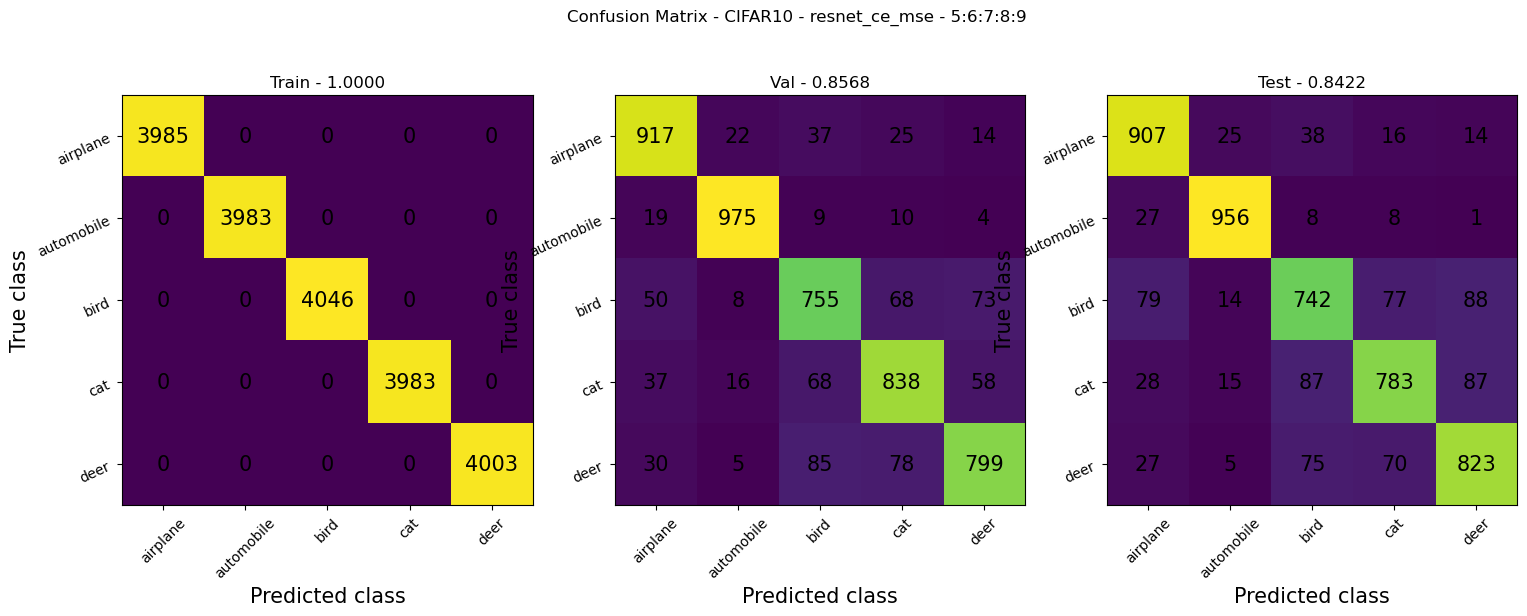

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

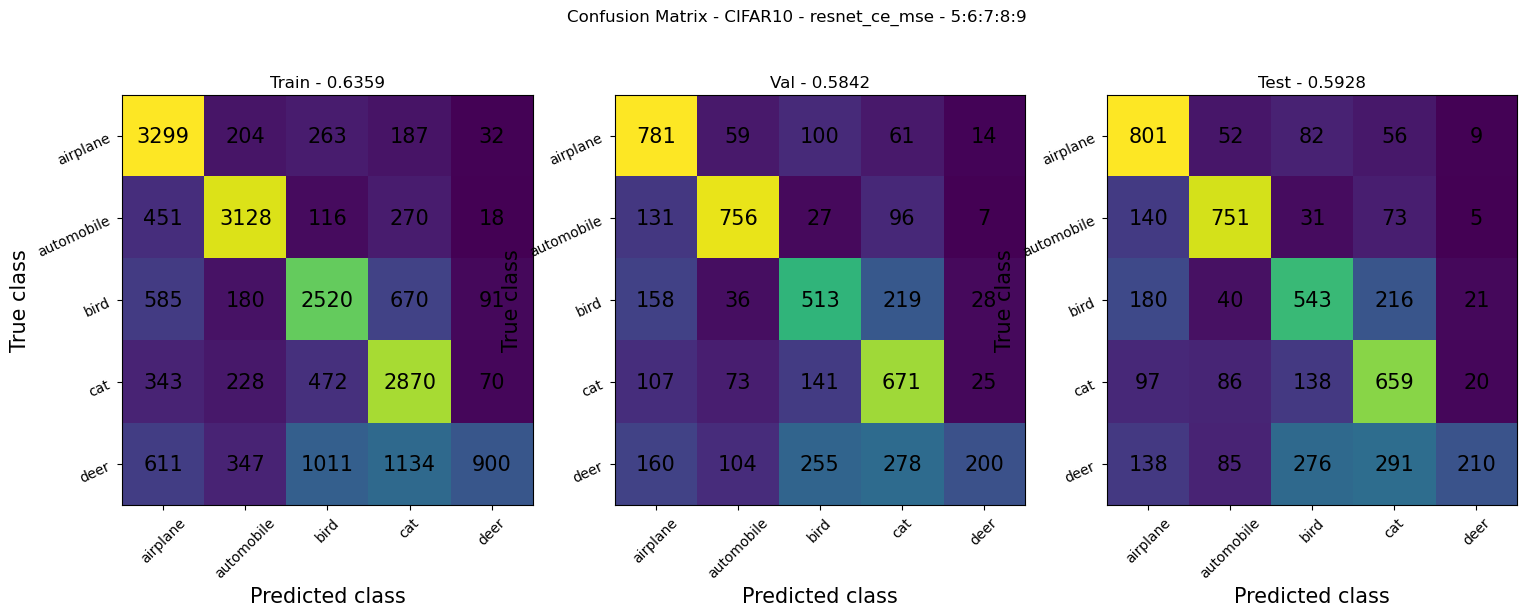

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5000, 2) (5000, 2)


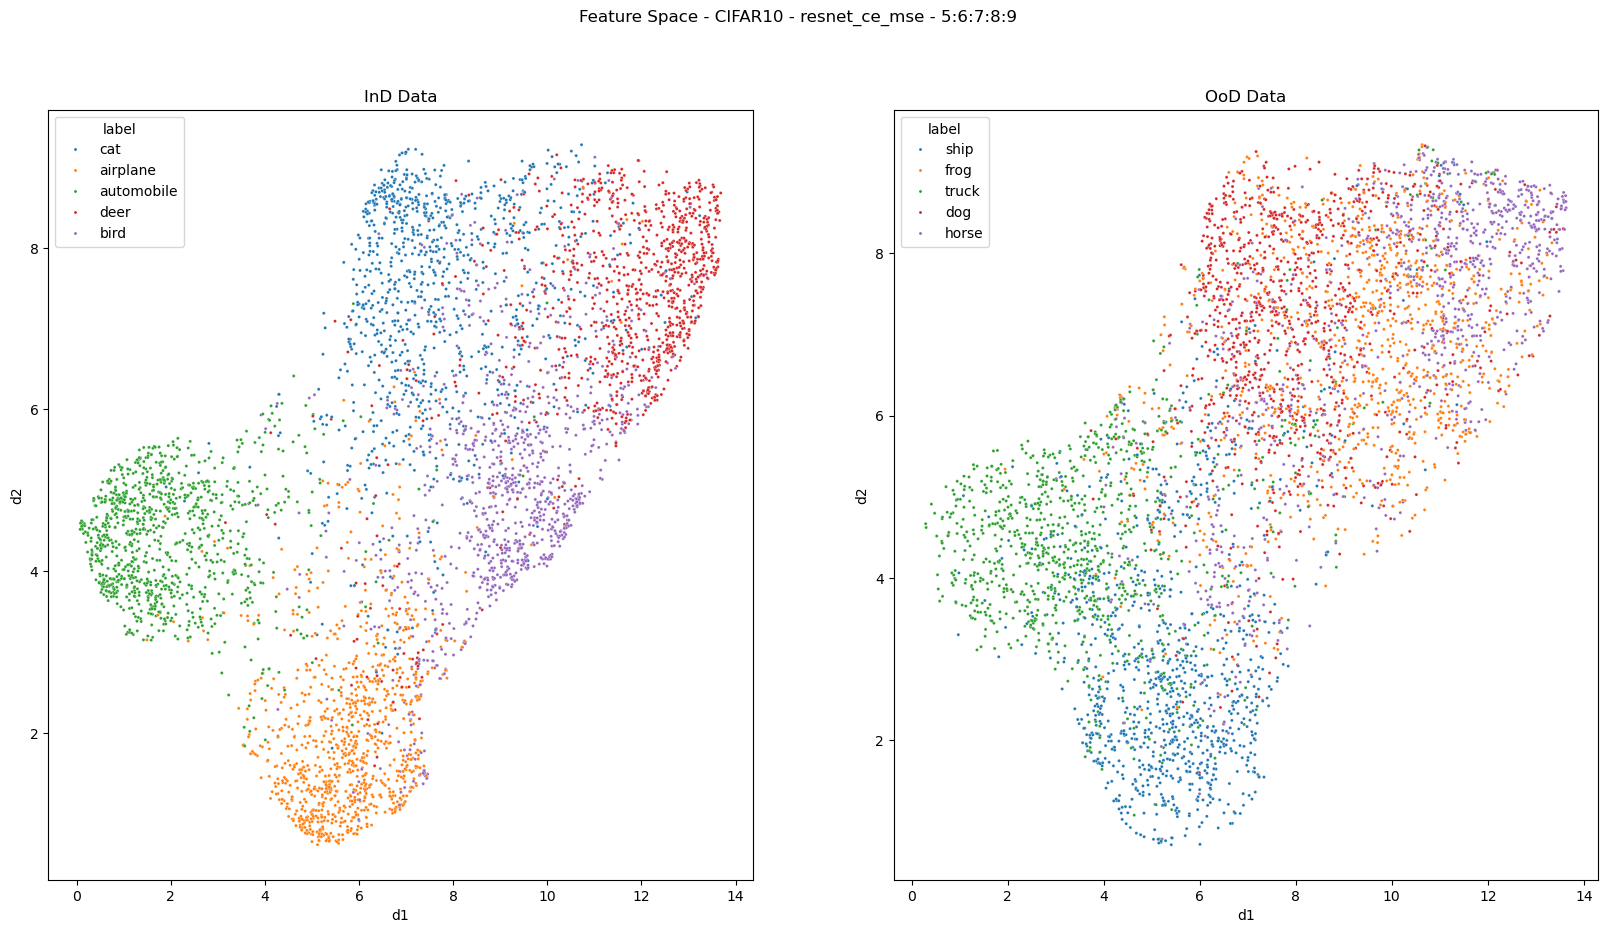

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

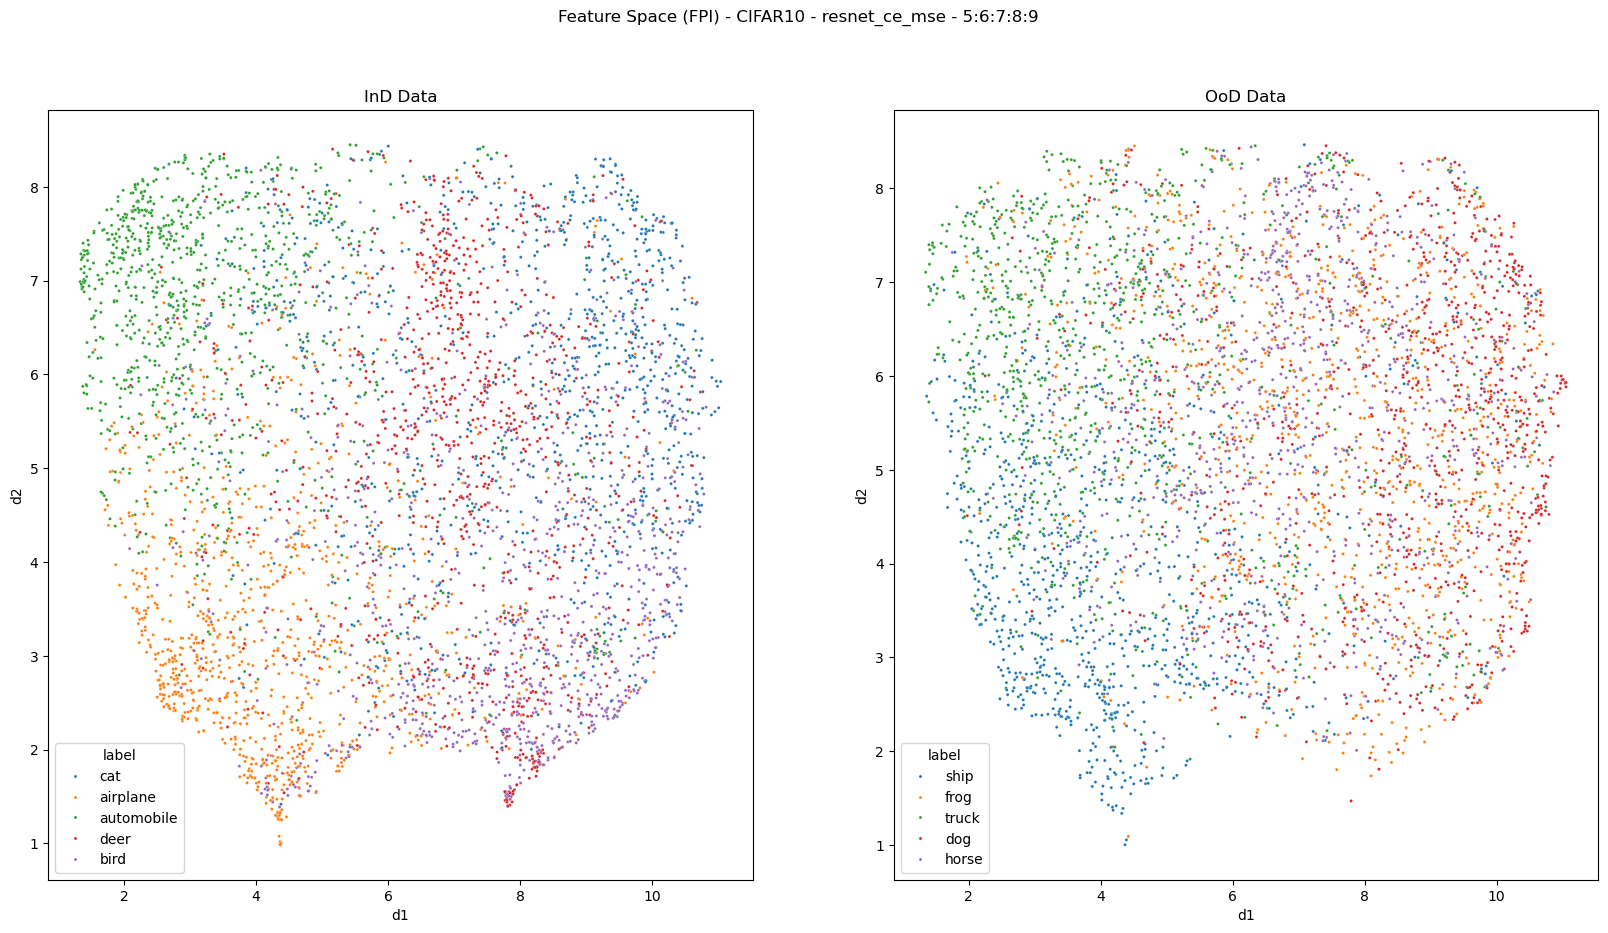

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

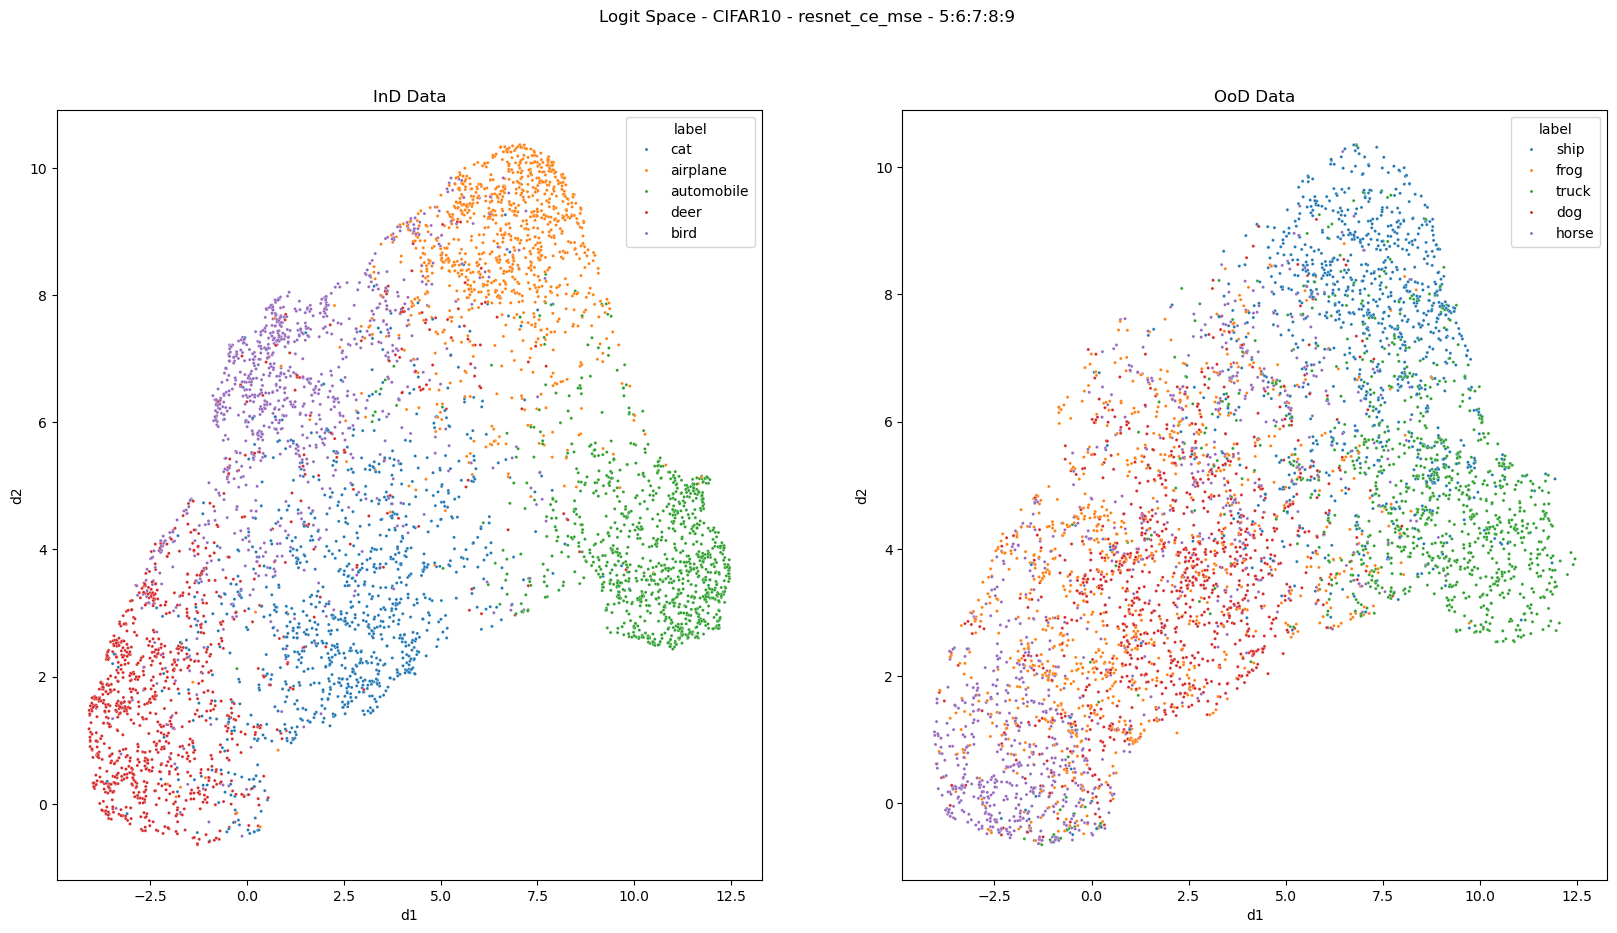

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

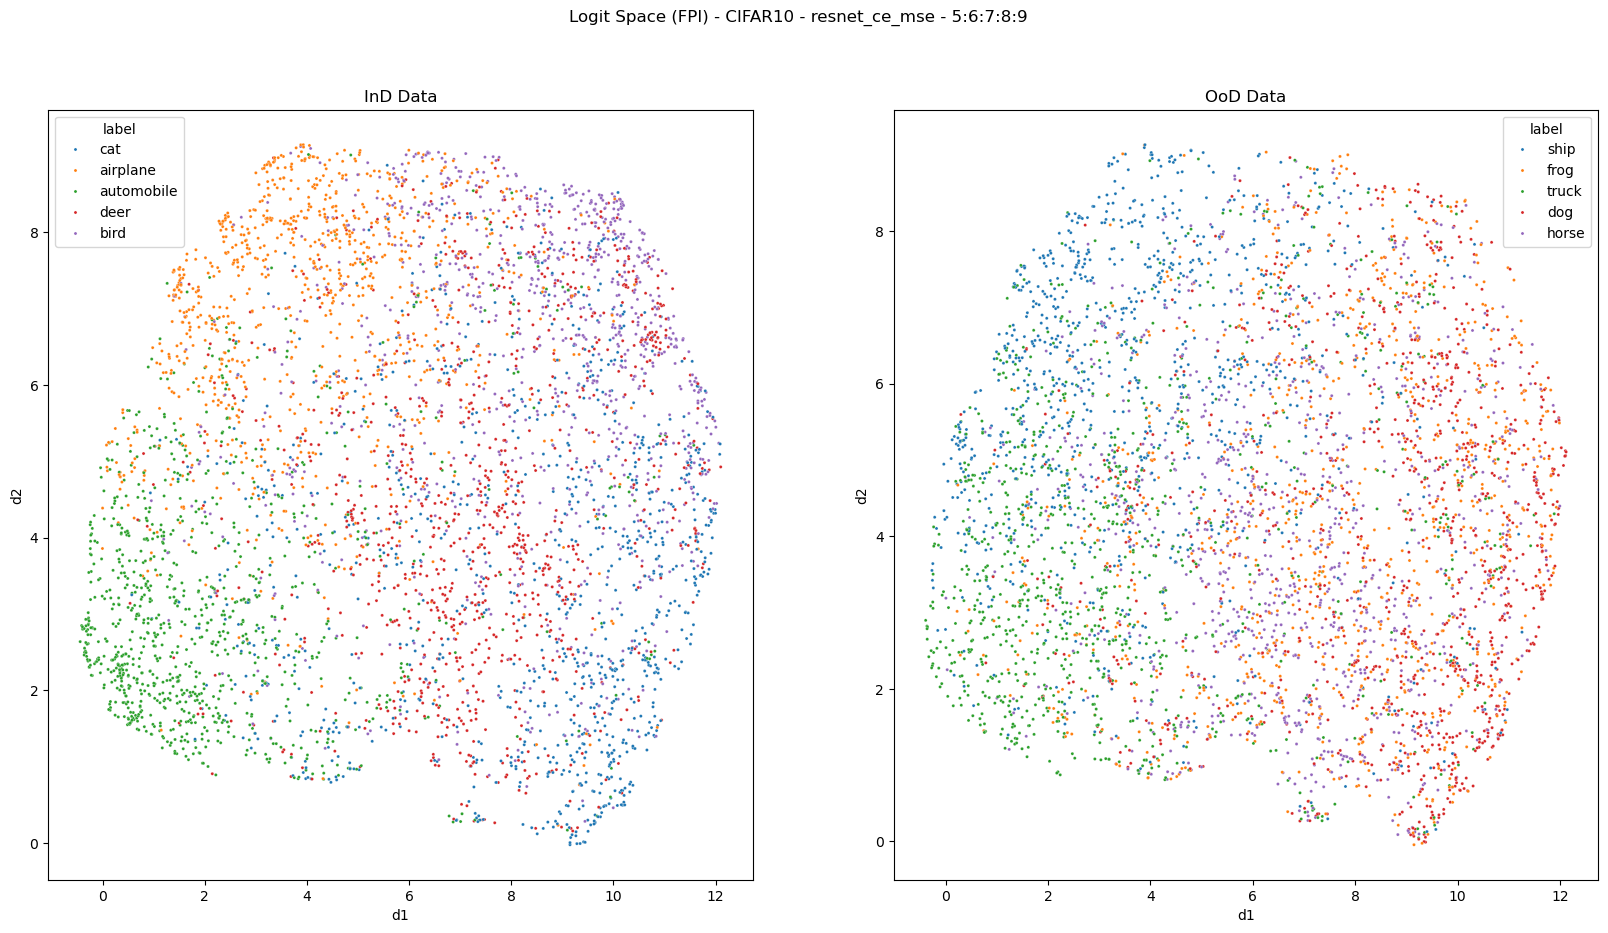

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

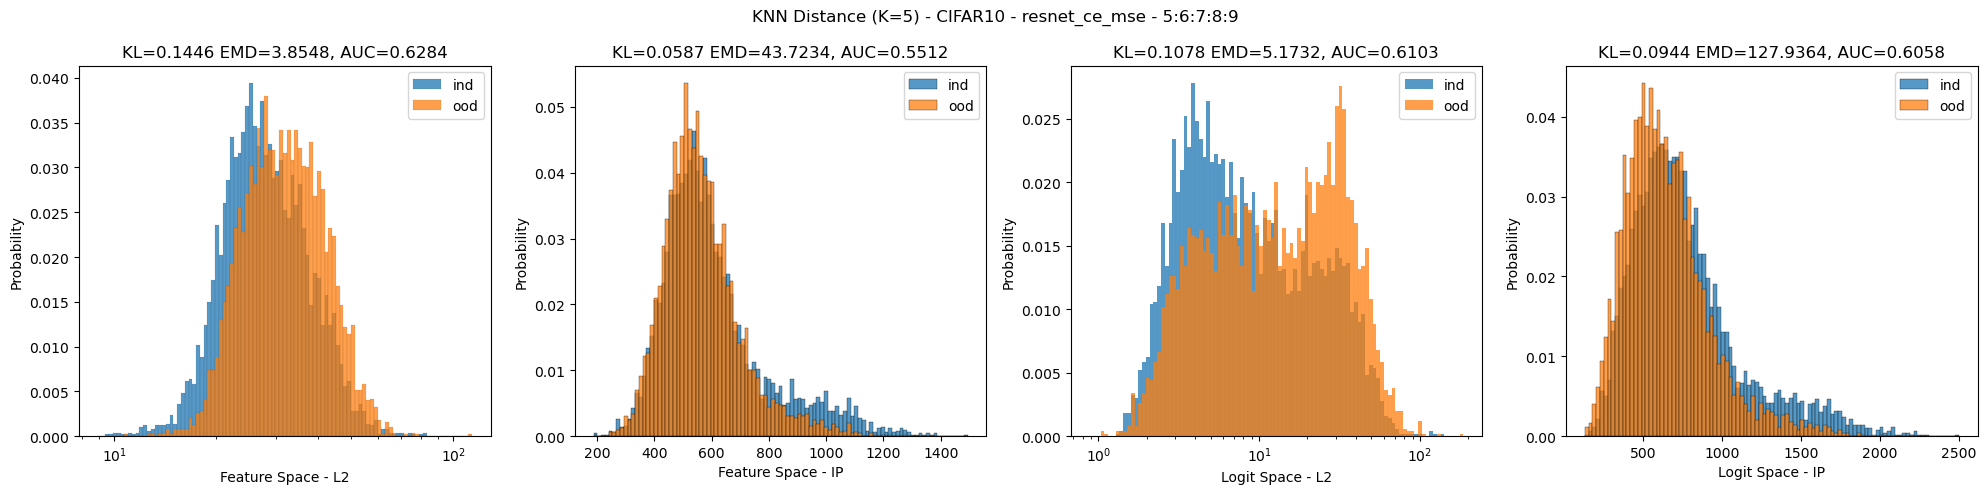

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

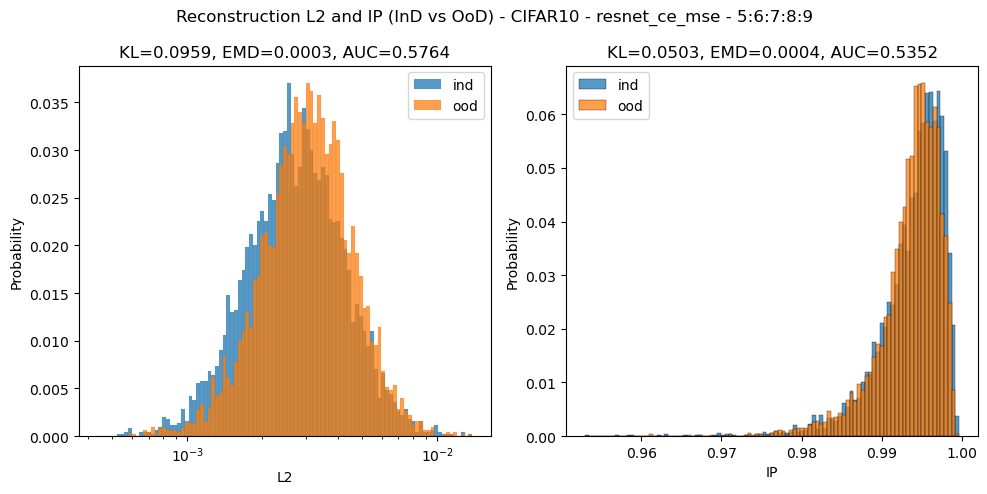

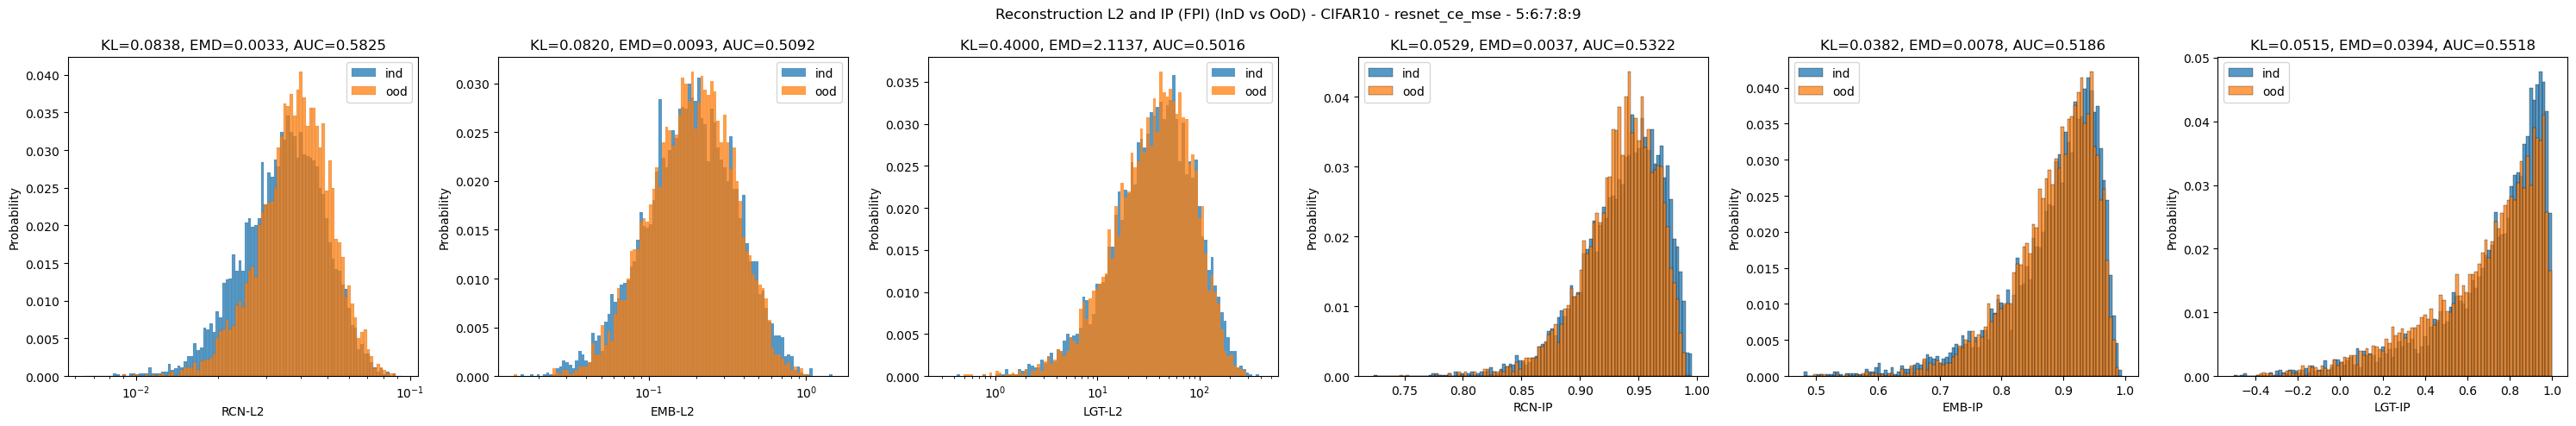

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

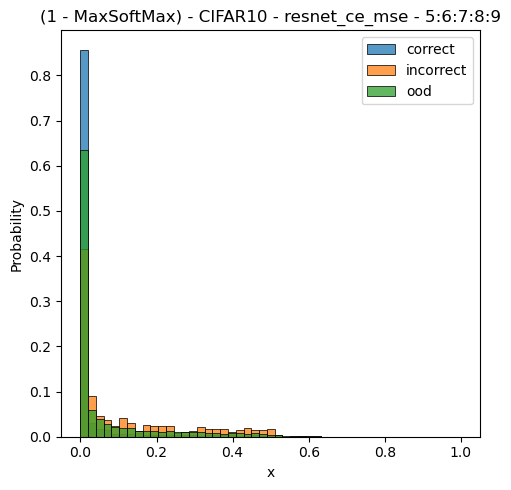

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

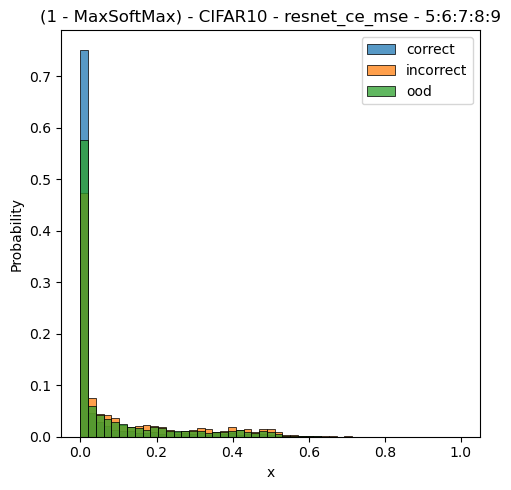

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [23]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)